# 7 Optical Sources

This notebook forms part of a series on [computational optical radiometry](https://github.com/NelisW/ComputationalRadiometry#computational-optical-radiometry-with-pyradi).  The notebooks can be downloaded from [Github](https://github.com/NelisW/ComputationalRadiometry#computational-optical-radiometry-with-pyradi). These notebooks are constantly revised and updated, please revisit from time to time.  

[<img src="https://zenodo.org/badge/doi/10.5281/zenodo.9910.png"   align="left"/>](http://dx.doi.org/10.5281/zenodo.9910)

The date of this document and module versions used in this document are given at the end of the file.  
Feedback is appreciated: neliswillers at gmail dot com.

## Overview

The pyradi library has a reasonably complete collection of Planck radiator models, both spectral and wide band. A comprehensive collection of physical constants, pertinent to optical radiation is also included.  

The first part of this notebook introduces these functions in the [`pyradi.ryplanck`](http://nelisw.github.io/pyradi-docs/_build/html/ryplanck.html#pyradi.ryplanck) library.

The second part provides a simple model for scene radiance and the electron counts that can be expected in a detector charge well for the scene flux. These calculations are made with the `pyradi.rypflux` library.

The third part of the notebook provides some programming details and tricks on how the Planck functions are implemented.

We use the material developed in *Electro-Optical System Analysis and Design: A Radiometry Perspective*, CJ Willers, SPIE, DOI: 10.1117/3.1001964, 2013 (\url{http://spie.org/Publications/Book/2021423}). 

In [1]:
# to prepare the Python computing environment
import scipy.constants as const
import pandas as pd
import numpy as np

import pyradi.rypflux as rypflux
import pyradi.ryplot as ryplot
import pyradi.ryutils as ryutils
import pyradi.ryplanck as ryplanck
import pyradi.rystare as rystare
import pyradi.ryfiles as ryfiles
import pyradi.rymodtran as rymodtran

%matplotlib inline

from IPython.display import display
from IPython.display import Image
from IPython.display import HTML

## Watch out for <font color="red">integer</font> numbers

It seems that Numpy interprets 400 as an integer int32. When this int32 value is raised to the fourth power, the value overflows, resulting in a _negative_ number.  This error can easily happen when entering integer temperature values, raised to a high power.  

In [`ryplanck`](http://nelisw.github.io/pyradi-docs/_build/html/ryplanck.html#module-pyradi.ryplanck), all temperature input values are always converted to float with `.astype(float)` (but only in [`ryplanck`](http://nelisw.github.io/pyradi-docs/_build/html/ryplanck.html#module-pyradi.ryplanck)).

In [2]:
import numpy as np
tt = np.asarray([400, 500])
print(tt.dtype)
print(np.power(tt, 4))

tt = np.asarray([400, 500]).astype(float)
print(tt.dtype)
print(np.power(tt, 4))


int32
[ -169803776 -1924509440]
float64
[2.56e+10 6.25e+10]


## Physical constants

This module uses the CODATA physical constants to derive the constants required for radiation calculations. The constants can be printed as a full set, or these can be accessed individually.  The CODATA constants are part of the SciPy library [`scipy.constants`](http://docs.scipy.org/doc/scipy/reference/constants.html), a comprehensive set of easy-to-access constants.  Where the values are available in `scipy.constants` these are used, if not the values are calculated in the `ryplanck` module.

For more details on CODATA see
<http://physics.nist.gov/cuu/pdf/RevModPhysCODATA2010.pdf>.

In [3]:
import pyradi.ryplanck as ryplanck
print('c (directly from scipy.constants) = {:.14e} m/s\n'.format(ryplanck.const.c))
ryplanck.pconst.printConstants()

c (directly from scipy.constants) = 2.99792458000000e+08 m/s

h = 6.62607015000000e-34 Js
c = 2.99792458000000e+08 m/s
k = 1.38064900000000e-23 J/K
q = 1.60217663400000e-19 C
 
pi = 3.14159265358979e+00
e = 2.71828182845905e+00
zeta(3) = 1.20205690315959e+00
a2 = 1.59362426004004e+00, root of 2(1-exp(-x))-x
a3 = 2.82143937212208e+00, root of 3(1-exp(-x))-x
a4 = 3.92069039487289e+00, root of 4(1-exp(-x))-x
a5 = 4.96511423174429e+00, root of 5(1-exp(-x))-x
 
sigmae = 5.67037441900000e-08 W/(m^2 K^4)
sigmaq = 1.52046085939314e+15 q/(s m^2 K^3)
 
c1em = 3.74177185219276e-16 with wavelenth in m
c1qm = 1.88365156730885e+09 with wavelenth in m
c2m = 1.43877687750393e-02 with wavelenth in m
 
c1el = 3.74177185219276e+08 with wavelenth in $\mu$m
c1ql = 1.88365156730885e+27 with wavelenth in $\mu$m
c2l = 1.43877687750393e+04 with wavelenth in $\mu$m
 
c1en = 3.74177185219276e-08 with wavenumber in cm$^{-1}$
c1qn = 1.88365156730885e+15 with wavenumber in cm$^{-1}$
c2n = 1.43877687750393e+00 with 

## Planck radiation law functions

(Sec. 3.1) The equations describing the Planck radiation law are available with spectral variables for wavelength, wavenumber or frequency. The exitance calculation is available in radiant units (watts) and photon rate units (quanta per second).  The Planck-law temperature derivatives are also available.

All the functions assume wavelength in micrometres ($\mu$m), wavenumber in cm$^{-1}$ and frequency in hertz.  All return values are in area units of m$^2$.  Values returned are expressed in exitance units [e.g., W/(m$^2$)], radiance units [e.g., W/(m$^2$.sr)] can be obtained by dividing the output by `numpy.pi`.

The Planck law functions have the form: [`ryplanck.planck`](http://nelisw.github.io/pyradi-docs/_build/html/ryplanck.html#pyradi.ryplanck.planck) or `planckxx` where two-letter code `xx` denotes the type of spectral variable and return type (see below).

The `ryplanck.planck(spectral, temperature, type='el')` function docstring states as follows:

    Calculates the Planck law spectral exitance from a surface at the stated 
    temperature. Temperature can be a scalar, a list or an array. Exitance can 
    be given in radiant or photon rate units, depending on user input in type.

    Args:
        | spectral (scalar, np.array (N,) or (N,1)):  spectral vector.
        | temperature (scalar, list[M], np.array (M,), (M,1) or (1,M)):  
                    Temperature in [K]
        | type (string):
        |  'e' signifies Radiant values in [W/m^2.*].
        |  'q' signifies photon rate values  [quanta/(s.m^2.*)].
        |  'l' signifies wavelength spectral vector  [micrometer].
        |  'n' signifies wavenumber spectral vector [cm-1].
        |  'f' signifies frequency spectral vecor [Hz].

    Returns:
        | (scalar, np.array[N,M]):  spectral radiant exitance (not radiance) 
                  in units selected.
        | For type = 'el' units will be [W/(m^2.um)].
        | For type = 'qf' units will be [q/(s.m^2.Hz)].
        | Other return types are similarly defined as above.
        | Returns None on error.

    Raises:
        | No exception is raised, returns None on error.


The first function parameter is a spectral vector, typically with shape (N,) or (N,1) but strictly a colum vector [not a row vector shape (1,N)]. 
This spectral domain type must be indicated by the 
appropriate character in the third parameter.

The second parameter is the object temperature  in kelvin.  The temperature values can be a scalar, a list, or a column vector with shape (M,), (M,1), or (1,M), but not of shape shape (Q,M).

The third parameter is a string denoting the calculation required. The first character in the string must be one of 'e' for radiant units or 'q' for photon rate units. The second character in the string must be one of  'l' for wavelength, 'n' for wavenumber, or 'f' for frequency. 

The return value will be in the format as requested in the third parameter:  
- `'el'` will return exitance in units of W/(m$^2$.$\mu$m), calling [`ryplanck.planckel`](http://nelisw.github.io/pyradi-docs/_build/html/ryplanck.html#pyradi.ryplanck.planckel)       
- `'ql'` will return exitance in units of q/(s.m$^2$.$\mu$m), calling [`ryplanck.planckql`](http://nelisw.github.io/pyradi-docs/_build/html/ryplanck.html#pyradi.ryplanck.planckql)    
- `'en'` will return exitance in units of W/(m$^2$.cm$^{-1}$), calling [`ryplanck.plancken`](http://nelisw.github.io/pyradi-docs/_build/html/ryplanck.html#pyradi.ryplanck.plancken)      
- `'qn'` will return exitance in units of q/(s.m$^2$ cm$^{-1}$), calling [`ryplanck.planckqn`](http://nelisw.github.io/pyradi-docs/_build/html/ryplanck.html#pyradi.ryplanck.planckqn)      
- `'ef'` will return exitance in units of W/(m$^2$.Hz), calling [`ryplanck.planckef`](http://nelisw.github.io/pyradi-docs/_build/html/ryplanck.html#pyradi.ryplanck.planckef)        
- `'qf'` will return exitance in units of q/(s.m$^2$.Hz), calling [`ryplanck.planckqf`](http://nelisw.github.io/pyradi-docs/_build/html/ryplanck.html#pyradi.ryplanck.planckqf)       

The `ryplanck.planckxx(spectral, temperature)` forms have only two parameters: spectral and temperature.

In addition to to the series of `planckxx` funtions there are a similar series of `dplnckxx` series  and [`ryplanck.dplanck`](http://nelisw.github.io/pyradi-docs/_build/html/ryplanck.html#pyradi.ryplanck.dplanck) to calculate the temperature derivative of the Planck law. These functions have the same function parameters as for `planckxx`.  The return values are similar, except that these have an additional unit (1/K).

The [`ryplanck.planck`](http://nelisw.github.io/pyradi-docs/_build/html/ryplanck.html#pyradi.ryplanck.planck) and [`ryplanck.dplanck`](http://nelisw.github.io/pyradi-docs/_build/html/ryplanck.html#pyradi.ryplanck.dplanck) functions can take different data types for the spectral and temperature parameters.

Either or both `spectral` and `temperature` can be scalar, in which case the return type is a scalar.

In [4]:
import pyradi.ryplanck as ryplanck
print(ryplanck.planck(10, 1000, 'el').shape)

()






If `spectral` is a numpy array, it must have shape (N,) or (N,1).  Row vectors of shape (1,N) is not allowed

In [5]:
wl = np.linspace(1, 15, 101).reshape(-1,)
print(ryplanck.planck(wl, 1000., 'el').shape)
wl = np.linspace(1, 15, 101).reshape(-1,1)
print(ryplanck.planck(wl, 1000., 'el').shape)
# Error! shape (1,N) not allowed
# wl = np.linspace(1, 15, 101).reshape(1,-1,) 
# print(ryplanck.planck(wl, 1000, 'el').shape)

(101,)
(101,)


Temperature can be a scalar, a list, or any form of vector with shape (M,), (M,1), or (1,M), but not of shape (Q,M).

In [6]:
wl = np.linspace(1, 15, 101).reshape(-1,)
print(ryplanck.planck(wl, 200., 'el').shape)
print(ryplanck.planck(wl, [200.,400.], 'el').shape)
print(ryplanck.planck(wl, np.asarray([200.,400.,500.]).reshape(-1,), 'el').shape)
print(ryplanck.planck(wl, np.asarray([200.,400.]).reshape(-1,1), 'el').shape)
print(ryplanck.planck(wl, np.asarray([200.,400.]).reshape(1,-1), 'el').shape)
# Error! shape (Q,M) not allowed
# print(ryplanck.planck(wl, 1000 * np.ones((2,2)), 'el').shape) 

print(ryplanck.planck(5, [200.,400.], 'el').shape)

(101,)
(101, 2)
(101, 3)
(101, 2)
(101, 2)
(1, 2)


The return value of the [`ryplanck.planck`](http://nelisw.github.io/pyradi-docs/_build/html/ryplanck.html#pyradi.ryplanck.planck) and [`ryplanck.dplanck`](http://nelisw.github.io/pyradi-docs/_build/html/ryplanck.html#pyradi.ryplanck.dplanck) functions always have the spectral domain along the row direction (axis=0) and temperature domain along the column direction (axis=1).

The example above also shows how the [`ryplanck.planck`](http://nelisw.github.io/pyradi-docs/_build/html/ryplanck.html#pyradi.ryplanck.planck) and [`ryplanck.dplanck`](http://nelisw.github.io/pyradi-docs/_build/html/ryplanck.html#pyradi.ryplanck.dplanck) functions can be invoked  with multiple temperature values, allowing compact code and fast vectorised calculations.

## Stefan-Boltzman wideband exitance

The Stefan-Boltzman equation is available as [`ryplanck.stefanboltzman`](http://nelisw.github.io/pyradi-docs/_build/html/ryplanck.html#pyradi.ryplanck.stefanboltzman)  

    Calculates the total Planck law exitance, integrated over all wavelengths,
    from a surface at the stated temperature. Exitance can be given in radiant or
    photon rate units, depending on user input in type.

    Args:
        | temperature (float):  temperature scalar in [K].
        | type (string):  'e' for radiant or 'q' for photon rate exitance.

    Returns:
        | (float): integrated radiant exitance in  [W/m^2] or [q/(s.m^2)].
        | Returns a -1 if the type is not 'e' or 'q'

    Raises:
        | No exception is raised.


In [8]:
# %load_ext autoreload
# %autoreload 2
%matplotlib inline
import pyradi.ryplanck as ryplanck

temperature = 1000. # K
print('T={} Stefan-Boltzman={} W/m^2'.format(temperature, ryplanck.stefanboltzman(temperature,'e')))
print('T={} Stefan-Boltzman={} q/(s.m^2)'.format(temperature, ryplanck.stefanboltzman(temperature,'q')))

temperature = [1000, 2000] # K
print('T={} Stefan-Boltzman={} W/m^2'.format(temperature, ryplanck.stefanboltzman(temperature,'e')))
print('T={} Stefan-Boltzman={} q/(s.m^2)'.format(temperature, ryplanck.stefanboltzman(temperature,'q')))

temperature = np.asarray([1000, 2000])   # K
print('T={} Stefan-Boltzman={} W/m^2'.format(temperature, ryplanck.stefanboltzman(temperature,'e')))
print('T={} Stefan-Boltzman={} q/(s.m^2)'.format(temperature, ryplanck.stefanboltzman(temperature,'q')))

# Error! temperature is of shape (Q,M) returns value of -1
print('T={} Stefan-Boltzman={} q/(s.m^2)'.format(temperature, ryplanck.stefanboltzman(np.ones((2,2)),'e')))

T=1000.0 Stefan-Boltzman=56703.74419 W/m^2
T=1000.0 Stefan-Boltzman=1.5204608593931365e+24 q/(s.m^2)
T=[1000, 2000] Stefan-Boltzman=[ 56703.74419 907259.90704] W/m^2
T=[1000, 2000] Stefan-Boltzman=[1.52046086e+24 1.21636869e+25] q/(s.m^2)
T=[1000 2000] Stefan-Boltzman=[ 56703.74419 907259.90704] W/m^2
T=[1000 2000] Stefan-Boltzman=[1.52046086e+24 1.21636869e+25] q/(s.m^2)
ryplanck.stefanboltzman: temperature must be of shape (M,), (M,1) or (1,M)
T=[1000 2000] Stefan-Boltzman=-1 q/(s.m^2)


# Wien law

The Wien law is so simple that only the constants are provided.  The constants are as follows:

    ryplanck.pconst.wel  um.K     radiant and wavelength
    ryplanck.pconst.wql  um.K     photon rate and wavelength
    ryplanck.pconst.wen  cm-1/K   radiant and wavenumber
    ryplanck.pconst.wqn  cm-1/K   photon rate and wavenumber
    ryplanck.pconst.wef  Hz/K     radiant and frequency
    ryplanck.pconst.wqf  Hz/K     photon rate and frequency



In [10]:
print('Wien constant for radiant power and wavelength = {}'.format(ryplanck.pconst.wel))
print('Peak wavelength for object at {} K is {} um'.format(2850, ryplanck.pconst.wel/2850))


Wien constant for radiant power and wavelength = 2897.771955185163
Peak wavelength for object at 2850 K is 1.0167620895386535 um


K:\WorkN\pyradi\pyradi\pyradi\ryplot.py:1884: UserWarning:

Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.



<AxesSubplot:title={'center':'Wien law'}, xlabel='Temperature K', ylabel='Wavelength $\\mu$m'>

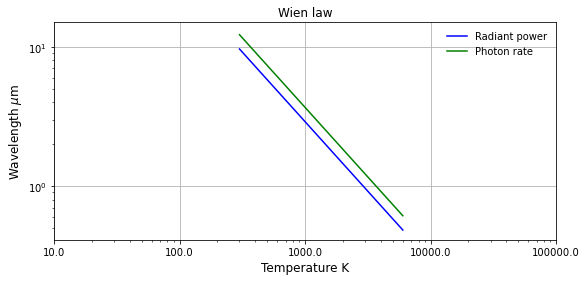

In [11]:
import pyradi.ryplot as ryplot
temperature = np.linspace(300, 6000, 101).astype(float)
wlwienel = ryplanck.pconst.wel / temperature
wlwienql = ryplanck.pconst.wql / temperature
lp = ryplot.Plotter(1,figsize=(9,4))
lp.logLog(1,temperature,wlwienel,label=['Radiant power'])
lp.logLog(1,temperature,wlwienql,"Wien law","Temperature K","Wavelength $\mu$m",
          label=['Photon rate'], drawGrid=True,
          pltaxis=[np.min(temperature), np.max(temperature), 0 ,15])


## Planck law graphs

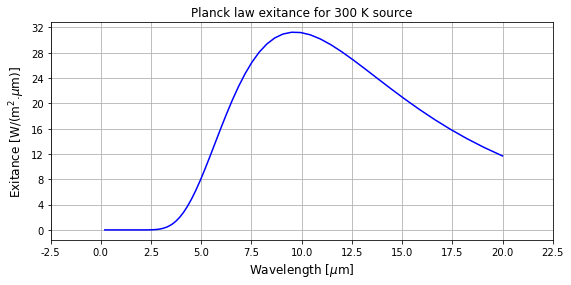

In [13]:
import pyradi.ryplot as ryplot
#plot a single planck curve on linear scale for 300K source
wl = np.logspace(np.log10(0.2), np.log10(20), num=100).reshape(-1, 1)
Mel = ryplanck.planck(wl, 300, type='el') # [W/(m$^2$.$\mu$m)]
lp = ryplot.Plotter(1,figsize=(9,4))
lp.plot(1,wl,Mel,"Planck law exitance for 300 K source","Wavelength [$\mu$m]",
            "Exitance [W/(m$^2$.$\mu$m)]");

<AxesSubplot:title={'center':'Photon Rate, Frequency Domain'}, xlabel='Frequency [Hz]', ylabel='Exitance [q/(s.m$^2$.Hz)]'>

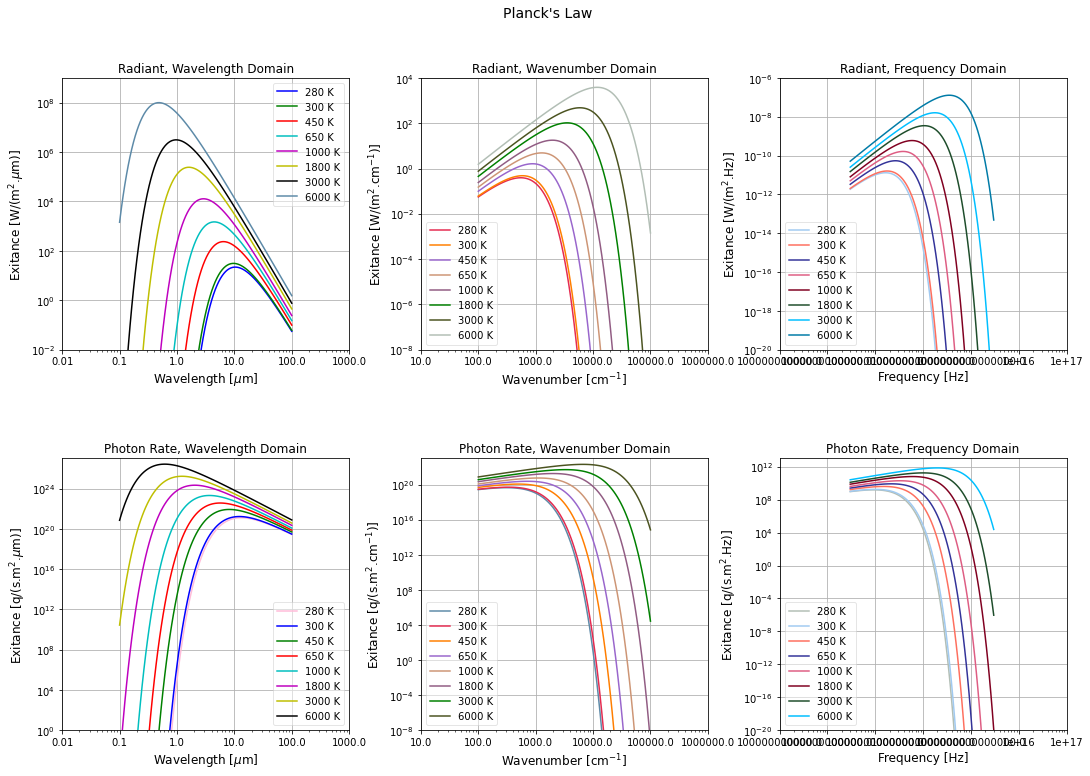

In [14]:
#plot all the planck functions.
wl = np.logspace(np.log10(0.1), np.log10(100), num=100).reshape(-1, 1)
n = np.logspace(np.log10(1e4/100),np.log10(1e4/0.1), num=100).reshape(-1, 1)
f = np.logspace(np.log10(ryplanck.const.c/ (100*1e-6)),np.log10(ryplanck.const.c/ (0.1*1e-6)), num=100).reshape(-1, 1)
temperature = [280, 300, 450, 650, 1000, 1800, 3000, 6000]

Mel = ryplanck.planck(wl, np.asarray(temperature).reshape(-1,1), type='el') # [W/(m$^2$.$\mu$m)]
Mql = ryplanck.planck(wl, np.asarray(temperature).reshape(-1,1), type='ql') # [q/(s.m$^2$.$\mu$m)]
Men = ryplanck.planck(n,  np.asarray(temperature).reshape(-1,1), type='en') # [W/(m$^2$.cm$^{-1}$)]
Mqn = ryplanck.planck(n,  np.asarray(temperature).reshape(-1,1), type='qn') # [q/(s.m$^2$.cm$^{-1}$)]
Mef = ryplanck.planck(f,  np.asarray(temperature).reshape(-1,1), type='ef') # [W/(m$^2$.Hz)]
Mqf = ryplanck.planck(f,  np.asarray(temperature).reshape(-1,1), type='qf') # [q/(s.m$^2$.Hz)]

legend = ["{0:.0f} K".format(temperature[0])]
for temp in temperature[1:] :
    legend.append("{0:.0f} K".format(temp))

fplanck = ryplot.Plotter(1, 2, 3,"Planck's Law", figsize=(18, 12))
fplanck.logLog(1, wl, Mel, "Radiant, Wavelength Domain","Wavelength [$\mu$m]", 
    "Exitance [W/(m$^2$.$\mu$m)]",legendAlpha=0.5, label=legend, drawGrid=True,
                pltaxis=[0.1, 100, 1e-2, 1e9])
fplanck.logLog(2, n, Men, "Radiant, Wavenumber Domain","Wavenumber [cm$^{-1}$]",
    "Exitance [W/(m$^2$.cm$^{-1}$)]",legendAlpha=0.5, label=legend, drawGrid=True,
                pltaxis=[100, 100000, 1e-8, 1e+4])
fplanck.logLog(3, f, Mef, "Radiant, Frequency Domain","Frequency [Hz]",
    "Exitance [W/(m$^2$.Hz)]",legendAlpha=0.5, label=legend, drawGrid=True,
                pltaxis=[3e12, 3e15, 1e-20, 1e-6])

fplanck.logLog(4, wl, Mql, "Photon Rate, Wavelength Domain","Wavelength [$\mu$m]",
    "Exitance [q/(s.m$^2$.$\mu$m)]",legendAlpha=0.5, label=legend, drawGrid=True,
                pltaxis=[0.1, 100, 1e-0, 1e27])
fplanck.logLog(5, n, Mqn, "Photon Rate, Wavenumber Domain","Wavenumber [cm$^{-1}$]",
    "Exitance [q/(s.m$^2$.cm$^{-1}$)]",legendAlpha=0.5, label=legend, drawGrid=True,
                pltaxis=[100, 100000, 1e-8, 1e+23])
fplanck.logLog(6, f, Mqf, "Photon Rate, Frequency Domain","Frequency [Hz]",
    "Exitance [q/(s.m$^2$.Hz)]",legendAlpha=0.5, label=legend, drawGrid=True,
                pltaxis=[3e12, 3e15, 1e-20, 1e+13])


<AxesSubplot:title={'center':'Photon Rate, Frequency Domain'}, xlabel='Frequency [Hz]', ylabel='dM/dT [q/(s.m$^2$.Hz.K)]'>

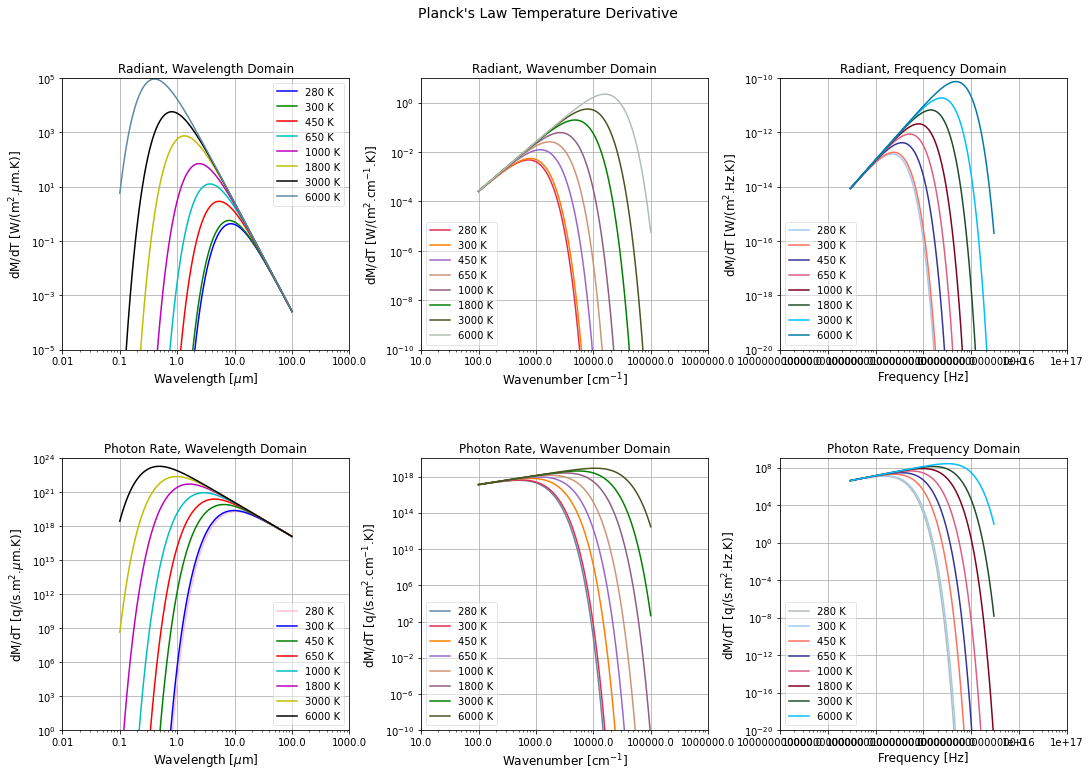

In [15]:
#now plot temperature derivatives
Mel = ryplanck.dplanck(wl, np.asarray(temperature).reshape(-1,1), type='el') # [W/(m$^2$.$\mu$m.K)]
Mql = ryplanck.dplanck(wl, np.asarray(temperature).reshape(-1,1), type='ql') # [q/(s.m$^2$.$\mu$m.K)]
Men = ryplanck.dplanck(n , np.asarray(temperature).reshape(-1,1), type='en') # [W/(m$^2$.cm$^{-1}$.K)]
Mqn = ryplanck.dplanck(n,  np.asarray(temperature).reshape(-1,1), type='qn') # [q/(s.m$^2$.cm$^{-1}$.K)]
Mef = ryplanck.dplanck(f,  np.asarray(temperature).reshape(-1,1), type='ef') # [W/(m$^2$.Hz.K)]
Mqf = ryplanck.dplanck(f,  np.asarray(temperature).reshape(-1,1), type='qf') # [q/(s.m$^2$.Hz.K)]

fdplanck = ryplot.Plotter(2, 2, 3,"Planck's Law Temperature Derivative", figsize=(18, 12))
fdplanck.logLog(1, wl, Mel, "Radiant, Wavelength Domain","Wavelength [$\mu$m]", 
    "dM/dT [W/(m$^2$.$\mu$m.K)]",legendAlpha=0.5, label=legend, drawGrid=True, 
                pltaxis=[0.1, 100, 1e-5, 1e5])
fdplanck.logLog(2, n, Men, "Radiant, Wavenumber Domain","Wavenumber [cm$^{-1}$]", 
    "dM/dT [W/(m$^2$.cm$^{-1}$.K)]",legendAlpha=0.5, label=legend, drawGrid=True, 
                pltaxis=[100, 100000, 1e-10, 1e+1])
fdplanck.logLog(3, f, Mef, "Radiant, Frequency Domain","Frequency [Hz]", 
    "dM/dT [W/(m$^2$.Hz.K)]",legendAlpha=0.5, label=legend, drawGrid=True, 
                pltaxis=[3e12, 3e15, 1e-20, 1e-10])

fdplanck.logLog(4, wl, Mql, "Photon Rate, Wavelength Domain","Wavelength [$\mu$m]", 
    "dM/dT [q/(s.m$^2$.$\mu$m.K)]",legendAlpha=0.5, label=legend, drawGrid=True, 
                pltaxis=[0.1, 100, 1e-0, 1e24])
fdplanck.logLog(5, n, Mqn, "Photon Rate, Wavenumber Domain","Wavenumber [cm$^{-1}$]", 
    "dM/dT [q/(s.m$^2$.cm$^{-1}$.K)]",legendAlpha=0.5, label=legend, drawGrid=True, 
                pltaxis=[100, 100000, 1e-10, 1e+20])
fdplanck.logLog(6, f, Mqf, "Photon Rate, Frequency Domain","Frequency [Hz]", 
    "dM/dT [q/(s.m$^2$.Hz.K)]",legendAlpha=0.5, label=legend, drawGrid=True, 
                pltaxis=[3e12, 3e15, 1e-20, 1e+9])


## Example applications

### The number of bits required to express colour ratio

Calculate the number of bits required in an image to express the colour ratio between an MTV flare and a relatively cold aircraft fuselage.  It is assumed here that the flare and fuselage are resolved, i.e., the individual image pixels are completely filled by the flare and fuselage respectively.  First calculate the radiance ratio of aircraft fuselage to MTV flare in 3-5 um band.  The flare is modelled as a blackbody with temperature 2200 K and emissivity of 0.15.  The aircraft has a temperature of 250 K and an emissivity of 1.  The number of bits required is given by $\log_2(L_{\rm flare}/L_{\rm aircraft})$

In [17]:
wl = np.linspace(3.5, 5, 201)
flareEmis = 0.15
flareTemp = 2200
flareM = flareEmis * np.trapz(ryplanck.planckel(wl,flareTemp).reshape(-1, 1),wl, axis=0)[0]
#aircraft fuselage temperature is 250 K. emissivity=1,
aircraftEmis = 1.0
aircraftTemp = 250
aircraftM =  aircraftEmis *np.trapz(ryplanck.planckel(wl,aircraftTemp).reshape(-1, 1),wl, axis=0)[0]
print('Mflare    = {0:.2f} W/m2'.format(flareM))
print('Maircraft = {0:.1f} W/m2'.format(aircraftM))
print('Colour ratio: ratio={0:.3e} minimum number of bits required={1:.1f}'.\
    format(flareM/aircraftM,  np.log2(flareM/aircraftM)))

Mflare    = 17583.36 W/m2
Maircraft = 0.7 W/m2
Colour ratio: ratio=2.625e+04 minimum number of bits required=14.7


### Cumulative blackbody curves

The following code produces (Fig 3.4) in the book. The top figure shows the spectral radiance of a few real-world objects. The bottom graph shows the normalised cumulative radiance of the same objects. The bottom graph is useful to estimate the percentage of total radiance above/below a wavelength.  From this curve it is evident that a tungsten lamp radiates less than 10% of its total flux in the visual spectral band. From this graph it can be concluded that approximately 40% of the sun's output is in the visual spectral band.

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


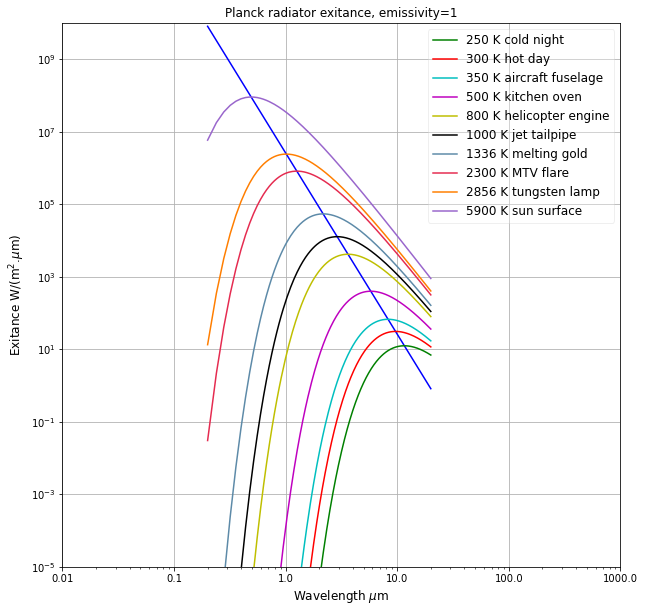

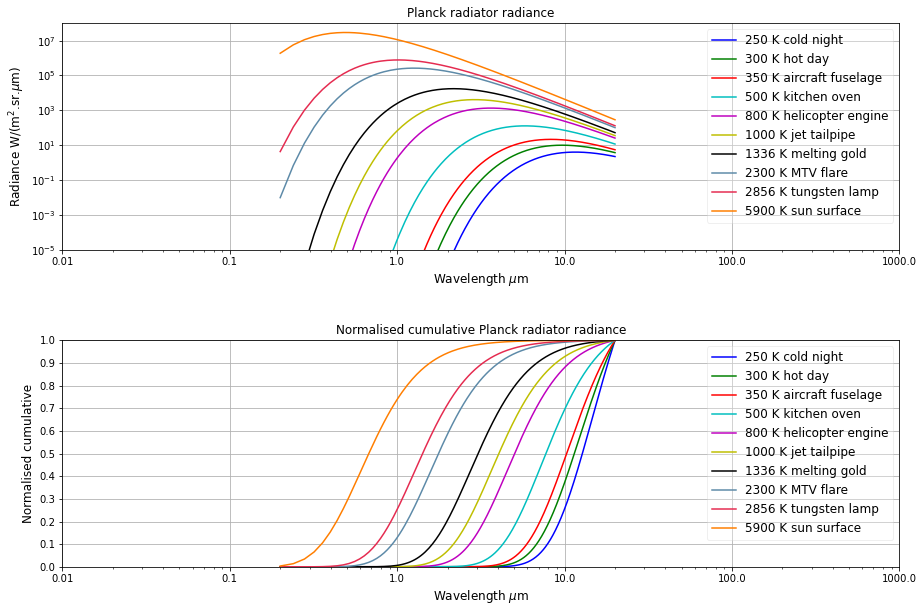

In [19]:
wl = np.linspace(0.2, 20, 501)
tmpr = [250, 300, 350, 500, 800,1000, 1336, 2300, 2856, 5900]
strL = ['cold night', 'hot day', 'aircraft fuselage','kitchen oven', 'helicopter engine','jet tailpipe', 'melting gold', 
        'MTV flare','tungsten lamp', 'sun surface']
L = ryplanck.planckel(wl,tmpr) / np.pi
Lcum = np.cumsum(L, axis=0)
Lcum = Lcum / np.max(Lcum, axis=0)

Lw = []
tmprw = ryplanck.pconst.wel / wl
for wli,tmprwi in zip(wl,tmprw):
    Lwi = ryplanck.planckel(wli,tmprwi) / np.pi
    Lw.append(Lwi)
Lw = np.asarray(Lw)


fc = ryplot.Plotter(1, 1, 1, figsize=(10, 10),doWarning=False)
fc.logLog(1, wl, np.pi*Lw)
legend = ['{} K {}'.format(item[0], item[1]) for item in zip(tmpr,strL)]
fc.logLog(1, wl, np.pi*L, "Planck radiator exitance, emissivity=1","Wavelength $\mu$m", 
    "Exitance W/(m$^2$.$\mu$m)",legendAlpha=0.3, label=legend, drawGrid=True, 
                pltaxis=[0.2, 20, 1e-5, 1e10], labelfsize=12)
fc.saveFig('thermalradiatorW.eps')

fc = ryplot.Plotter(2, 2, 1, figsize=(15, 10))
legend = ['{} K {}'.format(item[0], item[1]) for item in zip(tmpr,strL)]
fc.logLog(1, wl, L, "Planck radiator radiance","Wavelength $\mu$m", 
    "Radiance W/(m$^2$.sr.$\mu$m)",legendAlpha=0.3, label=legend, drawGrid=True, 
                pltaxis=[0.2, 20, 1e-5, 1e8], labelfsize=12)
fc.resetPlotCol()
fc.semilogX(2, wl, Lcum, "Normalised cumulative Planck radiator radiance","Wavelength $\mu$m", 
    "Normalised cumulative",legendAlpha=0.3, label=legend, drawGrid=True, 
                pltaxis=[0.2, 20, 0, 1], labelfsize=12);

### Reflected sunlight radiance

(Sec 3.7) derives an equation for the reflected sunlight radiance of a surface:
$$
L_\lambda=
\frac{
\epsilon_{\rm s}L_{{\rm bb}\lambda}(T_{ \rm s})
A_{\rm s}\tau_s\rho_d\cos\theta_i}{\pi R_{\rm sun}^2}
=
\psi  \epsilon_{\rm s}L_{{\rm bb}\lambda}(T_{ \rm s})\tau_s
\rho_d\cos\theta_i,
$$
where 
where $\epsilon_{\rm s}\approx 1$ is the emissivity of the sun's surface,
$T_s$ is the sun's surface temperature,
$\tau_s$ is the atmospheric transmittance between the sun and the surface, and $\theta_i$ is the angle between the surface normal and the sun vector.  The reflected sun radiance from a perfectly Lambertian surface is then given by $L_\lambda=\rho_d E_{\lambda \rm sun}/\pi$, where $\rho_d$ is the surface diffuse reflectance function. The constant $\psi  =A_{\rm sun}/(\pi R_{\rm sun}^2) =2.1757\times10^{-5}$ [sr/sr] follows from the geometry.

This really simple model does not account for sky radiance or light incident on the surface from other sources, applicable only to situations where the surface is directly illuminated by the sun, and with a object surface normal angle within 70 degrees or so from the sun direction. At larger angles the sun illumination decreases rapidly and other sources such terrain or sky radiance contribute increasingly more.

This section compares the simple model presented above with the  results obtained using a Modtran-calculated solar irradiance.

First to the imports and general preparation.

In [21]:
import pyradi.ryfiles as ryfiles
import pyradi.rymodtran as rymodtran
import pyradi.ryutils as ryutils

Modtran5 was used to calculate the solar irradiance and transmittance to space for a slant path. Modtran was used in direct solar irradiance mode, with Tropical profile with 23 km Rural visibility. The solar irradiance and transmittance to space is calculated at sea level, for a 45 degree zenith angle, on day 1.  The data files are available on the pyradi website.  Download, extract and plot the data.

In [23]:
tgzFilename = 'tropical-23krural-45deg-space.tgz'
destinationDir = '.'
tarFilename = 'tropical-23krural-45deg-space.tar'
url = 'https://raw.githubusercontent.com/NelisW/pyradi/master/pyradi/data/'
dlNames = ryfiles.downloadUntar(tgzFilename, url, destinationDir, tarFilename)

print('filesAvailable is {}'.format(dlNames))

filesAvailable is ['tropical-23krural-45deg-space.fl7', 'tropical-23krural-45deg-space.ltn']


The Modtran tape7 file contents is as follows (the first few lines):

    T F 1    3    3    0    1    1    1    1    1    1    1    0    0   0.000   0.00
        1    1    1    0    0    0  23.00000   0.00000   0.00000   0.00000   0.00000
     -99.000 -99.000 -99.000
     -99.00000 -99.00000 -99.00000  4.114728  0.000594 ! H2O & O3 COLUMNS [GM/CM2]
       36TROPICAL MODEL      
       0.00000 100.00000  45.00000 140.37962   0.87815   0.00000    0        0.00000
      -99  -99    1    0
     -99.00000 -99.00000 -99.00000 -99.00000 -99.00000 -99.00000   0.00000 -99.00000
       12495.0   33340.0       1.0       1.0NW        W1    
        0   0    0.000  0    0.000  0    1.000
        FREQ   TRANS     SOL TR  SOLAR
    12495.00  0.6706 5.03E-06 7.50E-06                                                              3.995E-01
    12496.00  0.4790 3.47E-06 7.23E-06                                                              7.360E-01
    12497.00  0.7075 5.07E-06 7.16E-06                                                              3.460E-01
    12498.00  0.6852 4.90E-06 7.15E-06                                                              3.780E-01
    12499.00  0.5352 3.84E-06 7.17E-06                                                              6.252E-01
    ...

Extract the data from the file using [`rymodtran.loadtape7`](http://nelisw.github.io/pyradi-docs/_build/html/rymodtran.html#pyradi.rymodtran.loadtape7). Then convert the spectral irradiance from W/(cm$^2$.cm$^{-1}$) to W/(m$^2$.$\mu$m) and plot the result.


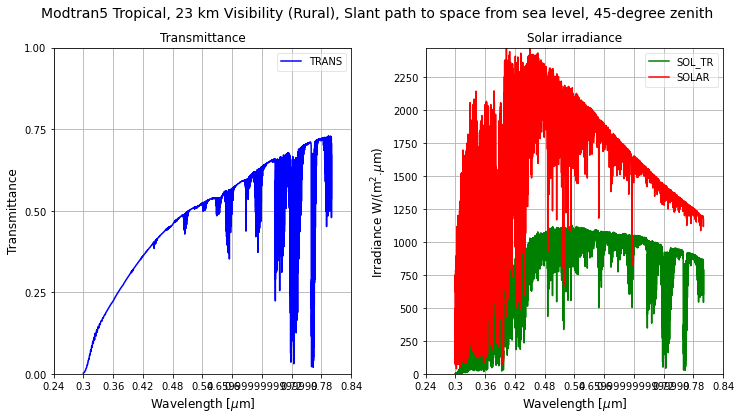

In [25]:
colSelect =  ['FREQ', 'TRANS', 'SOL_TR', 'SOLAR']
tape7= rymodtran.loadtape7("tropical-23krural-45deg-space.fl7", colSelect )
tSun = tape7[:,1]
wl, eSun = ryutils.convertSpectralDensity(tape7[:,0], tape7[:,2:4], type='nl')
eSun *= 1e4 # convert from cm^2 to m^2

mT = ryplot.Plotter(1, 1, 2,"Modtran5 Tropical, 23 km Visibility (Rural)"\
                   + ", Slant path to space from sea level, 45-degree zenith",figsize=(12,6))
mT.plot(1, wl, tSun, "Transmittance","Wavelength [$\mu$m]", "Transmittance",
       label=colSelect[1:],legendAlpha=0.5, pltaxis=[np.min(wl),np.max(wl), 0, 1],
       maxNX=10, maxNY=4);
mT.plot(2, wl, eSun, "Solar irradiance","Wavelength [$\mu$m]", "Irradiance W/(m$^2$.$\mu$m) ",
       label=colSelect[2:],legendAlpha=0.5, pltaxis=[np.min(wl),np.max(wl), 0, np.max(eSun)],
       maxNX=10, maxNY=10);

Consider an object with reflectance of one, with normal vector pointed towards the sun.

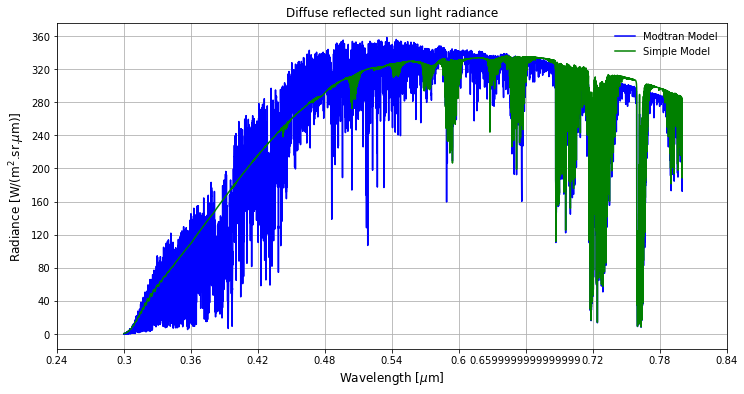

In [27]:
rho = 1  #perfectly white surface
theta = 0 # surface oriented towards the sun

Lsimp = 2.1757e-5 * (ryplanck.planckel(wl, 5900.) / np.pi) * tSun * rho * np.cos(theta)
Lmodt =  rho * np.cos(theta) * eSun[:,0] / np.pi

lp = ryplot.Plotter(1,1,1,figsize=(12,6))
lp.plot(1,wl,Lmodt,"Diffuse reflected sun light radiance","Wavelength [$\mu$m]",
            "Radiance [W/(m$^2$.sr.$\mu$m)]",label=['Modtran Model']);
lp.plot(1,wl,Lsimp,label=['Simple Model']);

It appears that the simple model fits the Modtran data reasonably closely.  The shape of the two radiance curves are somewhat different.  Considering the simplicity of the model the results are quite acceptable.

(Sec 2.10.3) Next calculate the luminance of the object's surface.  The photopic luminance of a source is defined as
$$
L_\nu=\int_0^\infty K_{\rm max} V_\lambda L_{e\lambda} d \lambda,
$$
where
$K_\lambda=K_{\rm max}V_\lambda$ is the spectral photopic efficacy,
$V_\lambda$ is the photopic efficiency,
$K_{\rm max}=683$ lm/W is the maximum value of photopic
efficacy, referenced to a 2042-K blackbody standard source, and
$L_{e\lambda}$ is the source's  radiance.  The spectral shape of photopic luminous efficiency is can be _roughly  approximated_ by 
$$
V_\lambda=1.019\exp(-285.51(\lambda - 0.5591)^2).
$$
There are data tables from the CIE standards that describe this shape more accurately but this approximation is sufficient for the present requirement.

Surface luminance is 23440 lm/(m2.sr)


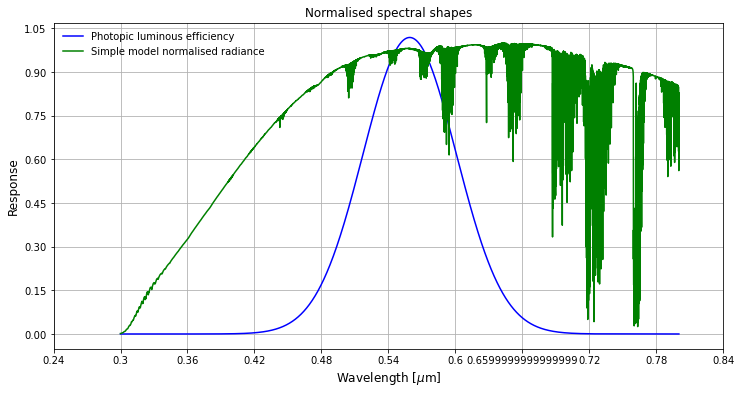

In [29]:
photLumEff = 1.019 * np.exp(-285.51 * (wl - 0.5591) ** 2 ).reshape(-1,)
#correct for sign because wl is decreasing (it was created from wavenumbers)
luminance =  - np.trapz(683. * photLumEff * Lsimp,wl, axis=0)

print('Surface luminance is {:.0f} lm/(m2.sr)'.format(luminance))
p = ryplot.Plotter(1,1,1,figsize=(12,6))
p.plot(1,wl,photLumEff , "Normalised spectral shapes","Wavelength [$\mu$m]",
            "Response", label=['Photopic luminous efficiency']);
p.plot(1,wl,Lsimp/np.max(Lsimp),label=['Simple model normalised radiance']);

According to [Wikipedia](https://en.wikipedia.org/wiki/Luminance) the sun has a (apparent?) luminance of 1.6e9 cd/m2 at noon, which, if converted with $\psi$=2.1757e-5 gives a value of 34811 lm/(m$^2$.sr). Comparing this to the value of 23440 lm/(m$^2$.sr) calculated above, yields a ratio of 1.48. Considering the fact that the Wikipedia atmosphere is not known and that the simple calculation is for a slant path of 45 degrees, the result from the simple model seems feasible.

## Scene radiance

### Low light scene radiance

This section develops a simple model for the reflected photon rate flux for low light scenes (thermal emission is not included).  The `pyradi.rypflux` library provides the simple models for scene illumination used here.


#### Source spectral content

The target object will either radiate by its own thermal self-emittance, reflected incident light, or both.  In the visible and near infrared bands the signal is mostly caused by reflection. At wavelengths beyond 6 $\mu$m the signal is mostly caused by thermal self-emission.  In the 3--5 $\mu$m spectral band the signal is caused by both sources.

We will be using the colour temperature as an approximation of source spectral content, in the visible and near infrared parts of the spectrum.  We will however use the sun's colour temperature for all spectral bands, because the sun's colour temperature is also approximately equal to the surface temperature.


<http://sizes.com/units/color_temperature.htm>  
<https://www.firstrays.com/bb1-1286570267-680/start/color_temp.htm>  
<http://www.clarkvision.com/articles/night.photography.image.processing/>  


We must be careful when using colour temperature, it does not mean that the object has that temperature. It does not even mean that the spectral content of the object can be described by a scaled spectrum of a radiator at that temperature. The colour temperature's only significance is that it very broadly describes the visual colour of an object.
From <https://en.wikipedia.org/wiki/Color_temperature>
''The color temperature of a light source is the temperature of an ideal blackbody radiator that radiates light of comparable hue to that of the light source. Color temperature is a characteristic of visible light that has important applications in lighting, photography, videography, publishing, manufacturing, astrophysics, horticulture, and other fields. In practice, color temperature is only meaningful for light sources that do in fact correspond somewhat closely to the radiation of some black body, i.e., those on a line from reddish/orange via yellow and more or less white to blueish white; it does not make sense to speak of the color temperature of, e.g., a green or a purple light. Color temperature is conventionally stated in the unit of absolute temperature, the Kelvin, having the unit symbol K.''

Source temperature is undefined if the source spectrum deviates significantly from the Planck law spectral shape. For example, for sources with little continuum and high spectral line variation (e.g., sodium and mercury lamps with small fluorescence) colour temperature has no meaning.

We will be using the colour temperature as an approximation of source spectral content, in the visible and near infrared parts of the spectrum.  We will however use the sun's colour temperature for all spectral bands, because the sun's colour temperature is also approximately equal to the surface temperature.

**The moon's colour temperature:**

<http://www.cast-lighting.com/landscape-articles/moonlighting-landscape-lighting-design-imitates-nature>
''It turns out that the moon absorbs twice as much violet as it does red. For this reason, the moon is slightly reddish. A full moon when it appears directly overhead has a color temperature of about 4,150 K. Compared to incandescent lighting (around 3,000 K), moonlight is slightly blue but not nearly as blue as a bright sunny day (as much as 10 000 K)''
 
''Johannes Purkinje, a 19th century physiologist, found that at very low light levels, the human eye could no longer  perceive the color red, but could still perceive blues and greens. This occurs because the eye's retinal cones (responsible for color perception) require a lot of light. At lower brightness levels, only the retinal rods are activated. These rods (responsible for seeing fine detail and contrast) can only respond to blues and greens.''

''The luminance level at which this perceptual shift occurs is at about .001 candelas/meters. Moonlight has about this same luminance level. This puts moonlight right at the threshold of the Purkinje Shift and this is why the moon appears slightly blue. It should be noted though, that the effect is so slight that the brain easily shifts its perception to judging the moon to be white. If we shift our gaze from the moon to the ground and other objects that it illuminates, the most noticeable effect is not only a blueish color but also an absence of all other colors.''

The `rypflux` module captures low light level lux values in the `rypflux.PFlux.lllux` dictionary. The values were originally published in the RCA/Burle Electro-Optics Handbook.  Copies of this book floats around the internet.

![images/burleEOHB-lowlightlux.png](images/burleEOHB-lowlightlux.png)

In [31]:
# to print the low light level lux values

pf = rypflux.PFlux()
print(pf.lllux)

dfPhotRates = pd.DataFrame(pf.lllux).transpose()
dfPhotRates.columns = ['Irradiance-lm/m2','ColourTemp','FracPhotop']

dfPhotRates.sort_values(by='Irradiance-lm/m2',inplace=True)
print(dfPhotRates)


{'Sun light': [107527, 5700, 1.0], 'Full sky light': [10752, 12000, 1.0], 'Overcast day': [1075, 6000, 1.0], 'Very dark day': [107, 7000, 1.0], 'Twilight': [10.8, 10000, 1.0], 'Deep twilight': [1.08, 10000, 0.8], 'Full moon': [0.108, 4150, 0.6], 'Quarter moon': [0.0108, 4150, 0.4], 'Star light': [0.0011, 5000, 0.2], 'Overcast night': [0.0001, 5000, 0.0]}
                Irradiance-lm/m2  ColourTemp  FracPhotop
Overcast night            0.0001      5000.0         0.0
Star light                0.0011      5000.0         0.2
Quarter moon              0.0108      4150.0         0.4
Full moon                 0.1080      4150.0         0.6
Deep twilight             1.0800     10000.0         0.8
Twilight                 10.8000     10000.0         1.0
Very dark day           107.0000      7000.0         1.0
Overcast day           1075.0000      6000.0         1.0
Full sky light        10752.0000     12000.0         1.0
Sun light            107527.0000      5700.0         1.0


### Relating photometric units with photon rate units

The illuminance table above shows the approximate illuminance levels for different scenarios.  The sensor models below require irradiance levels in units of q/(s.m$^s$), not lx/m$^2$. A conversion between the two unit systems is required.  This conversion requires two information elements: the illuminance magnitude and spectral content.  The magnitude is given in the table, and in the absence of any better information, we would assume the spectral content to be a scaled version of a thermal source at the colour temperature.  This use of colour temperature is extending beyond its original purpose and introduces an element of risk.  Yet the answer with risk is better than no answer at all.

If the luminance exceeds about $3$ lm/(m$^2$sr) [twilight], the eye is light-adapted, and the cones in the retina are operating. Under light-adapted conditions, the eye's spectral response is called photopic.
If the luminance is less than $3\times 10^{-5}$ lm/(m$^2$sr) [overcast night], the eye is dark-adapted. The cones are no longer sensitive, and the rods sense the light.Under dark-adapted conditions, the eye's spectral response is called scotopic.

Under scotopic vision, the eye is not sensitive to color and has no foveal vision. Between photopic and scotopic vision, the eye's response is called mesoptic.  Mesopic vision has a spectral response somewhere between photopic and scotopic vision.  In the table above the `FracPhotop` column shows my very rough mixing ratio of photopic and scotopix spectral curves to model mesopic vision.  These values are not validated and are purely guesswork.

The eye's photopic spectral response can be _roughly  approximated_ by:
\begin{equation}
V_\lambda=1.019\exp(-285.51(\lambda - 0.5591)^2).
\end{equation}

The eye's scotopic spectral response can be _roughly  approximated_ by:
\begin{equation}
V_\lambda^\prime=0.99234\exp(-321.1(\lambda - 0.5028)^2).
\end{equation}

There are also data tables from the CIE standards that describe this shape more accurately. The `ryutils` module has a function `luminousEfficiency` that returns luminous efficiency data for four different CIE curves as well as the equations shown above.

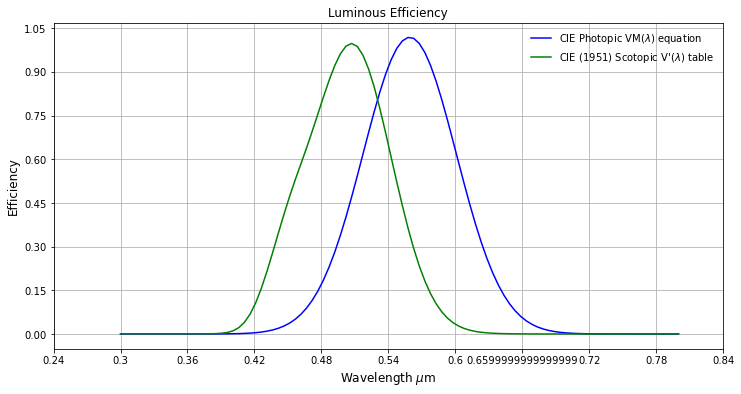

In [33]:
wl = np.linspace(0.3, 0.8, 100)
p = ryplot.Plotter(1,1,1,figsize=(12,6));
photLumEff,wl = ryutils.luminousEfficiency(vlamtype='photopic', wavelen=wl, eqnapprox=True)
p.plot(1,wl,photLumEff,label=['{} equation'.format('CIE Photopic VM($\lambda$)')]);
scotLumEff,wl = ryutils.luminousEfficiency(vlamtype='scotopic', wavelen=wl, eqnapprox=False)
p.plot(1,wl,scotLumEff,'Luminous Efficiency','Wavelength $\mu$m','Efficiency',
       label=['{} table'.format("CIE (1951) Scotopic V'($\lambda$)")]);


#### Extrapolating to other spectral bands

The photopic luminance of a source is defined as
\begin{equation}
L_\nu=\int_0^\infty K_{\rm max} V_\lambda L_{e\lambda}(T) d \lambda,
\end{equation}
where
$K_{\rm max}V_\lambda$ is the spectral photopic efficacy,
$V_\lambda$ is the photopic efficiency,
$K_{\rm max}=683$ lm/W is the maximum value of photopic
efficacy, referenced to a 2042-K blackbody standard source, and
$L_{e\lambda}$ is the source's  radiance.  

The scotopic  luminance of a source is defined as
\begin{equation}
 L_\nu=\int_0^\infty K_{\rm max}^\prime V_\lambda^\prime L_{e\lambda}(T) d \lambda,
\end{equation}
where
$K_{\rm max}^\prime V_\lambda^\prime$ is the spectral scotopic efficacy,
$V_\lambda^\prime$ is the scotopic efficiency,
$K_{\rm max}^\prime=1700$ lm/W is the maximum value of scotopic
efficacy, referenced to a 2042-K blackbody standard source, and
$L_{e\lambda}$ is the source's  radiance. 

The conversion between photometric and photon rate units is based on the calculation of a scaling factor $k$ given by solving the following equation.  Under strong light conditions the photopic equation should be used, whereas under very dark conditions the scotopic equation should be used.  In the mesopic range a somewhat arbitrary mix of the two is used.


\begin{equation}
 L_{\nu\textrm{table}} = k L_\nu=k\, 
 \left[
f_P K_{\rm max}\int_0^\infty  V_\lambda L_{e\lambda}(T) d \lambda
+
(1-f_P)K_{\rm max}^\prime\int_0^\infty  V_\lambda^\prime L_{e\lambda}(T) d \lambda
 \right]
\end{equation}
where $k$ is the fraction of the expected illuminance given the colour temperature,
and $f_P$ is the fraction of photopic flux (scotopic flux will be fraction $1-f_P$.  
Calculate $k$ for each entry in the table, using the stated luminance $L_\textrm{table}$ and colour temperature $T$.

Subsequently the wideband integrated photon radiance corresponding to the scenarios in the table can be determined from 

\begin{equation}
L_{q} = k\int_0^\infty  L_{q\lambda}(T) d \lambda 
\end{equation}

This procedure critically depends on the sources' spectral radiance in the various different spectral bands.  For this calculation the approach is taken  that for natural scenes the spectral shape can be modelled by a Planck curve  at the appropriate colour temperature.  City light has a very different spectral character and this derivation does not apply to such lighting conditions.

The closer the spectral bands are to the visible spectral band, the more accurate the results would be.  It is questionable whether the colour temperature in the infrared bands are relevant or correct, but there are no better available data.  


In [34]:
# to calculate the scene photon radiance or a surface with unity reflectance
dfPhotRates = pf.lllPhotonrates()
print(dfPhotRates)


                ColourTemp  FracPhotop  Irradiance-lm/m2  \
Overcast night      5000.0         0.0            0.0001   
Star light          5000.0         0.2            0.0011   
Quarter moon        4150.0         0.4            0.0108   
Full moon           4150.0         0.6            0.1080   
Deep twilight      10000.0         0.8            1.0800   
Twilight           10000.0         1.0           10.8000   
Very dark day       7000.0         1.0          107.0000   
Overcast day        6000.0         1.0         1075.0000   
Full sky light     12000.0         1.0        10752.0000   
Sun light           5700.0         1.0       107527.0000   

                Radiance-q/(s.m2.sr)-LWIR  Radiance-q/(s.m2.sr)-MWIR  \
Overcast night               1.098962e+10               4.126564e+10   
Star light                   1.352949e+11               5.080275e+11   
Quarter moon                 3.790939e+12               1.362623e+13   
Full moon                    4.295992e+13          

#### Quick validation

Of course these simple checks do not validate all the data points in the table, but they do validate the calculation.

##### Starlight irradiance

The report ''Night sky radiometric measurements during follow-on-evaluation testing of AN/PVS-7 (A,B) at Fort Benning, Ga'' R.J. Stefanik, Center for Night Vision and Electro-Optics, AMSEL-NV-TR-0079, AD-A211273, May 1989, published the following spectral starlight irradiance data 

![''](images/starlight-irradiance.png)

As validation check, simply consider the values at 0.5 $\mu$m and 0.8 $\mu$m and convert to SI units and photon rate. Energy per photon $h\nu=hc/\lambda$, in Joule.
$\Phi_q = \Phi_e/(h\nu) = \Phi_e \lambda/(hc)$

1.  At 0.5 $\mu$m starlight has an irradiance of 0.8 pW/(cm$^2$.nm) = 0.8e-05 W/(m$^2$.$\mu$m). This corresponds to a photon rate radiance of 1.67e+12 q/(s.m$^2$.sr) over the spectral width in the subsequent calculation.  This corresponds closely with the values calculated in the model (1.77e+12  q/(s.m$^2$.sr)).

1.  At 0.8 $\mu$m starlight has an irradiance of 2 pW/(cm$^2$.nm) = 2e-05 W/(m$^2$.$\mu$m). This corresponds to a photon rate radiance of 5.144402e+12 q/(s.m$^2$.sr) over the spectral width in the subsequent calculation.  This corresponds to a factor of 3.2 of the values calculated in the model (1.61e+12 q/(s.m$^2$.sr)).



In [35]:
print('Star light radiance in the visible {:e} q/(s.m2.sr)'.format(
        (0.69 - 0.43) * 0.8e-12 * 1e4 * 1e3 *.5e-6 / (np.pi * const.c * const.h)))
print('Star light radiance in the NIR {:e} q/(s.m2.sr)'.format(
        (0.9 - 0.7) * 2e-12 * 1e4 * 1e3 *.8e-6 / (np.pi * const.c * const.h)))
    

Star light radiance in the visible 1.666505e+12 q/(s.m2.sr)
Star light radiance in the NIR 5.127709e+12 q/(s.m2.sr)


##### Value of $k$ for direct sunlight

The value for k for direct sunlight is calculated in [W, Section 3.7], and found to be 2.17e-5 (when accounting for units differences), which corresponds well with the value of 1.96e-05 calculated here.  

###  Example application

Consider the photon flux for an example scenario (details are given in the code).  This example calculates the electron count in the detector charge well, as well as the associated photon noise for the signal.

See the notebook [09b-StaringArrayDetectors.ipynb](https://github.com/NelisW/ComputationalRadiometry/blob/master/09b-StaringArrayDetectors.ipynb) for theory.
The functions to calculate the electrons in the charge well are contained in [rystare.py](https://github.com/NelisW/pyradi/blob/master/pyradi/rystare.py).

In [36]:
# to evaluate typical electron count from different contributors

tauAtmo = 1
tauSun = 0.5
tauFilt = 1.
tauOpt = 0.8
quantEff = 0.7
rhoTarg = .3
cosTarg = 1.
inttime = 0.02
pfrac = 1.0
detarea = (10e-6)**2
fno = 2.
tmptr = 300.
tmptrOpt = 300.
emisscene = .8
scenarios =  dfPhotRates.index.values

print(scenarios)
print('electrons in charge well and photon noise')
for wl, specBand in zip([np.linspace(0.3, 0.8, 100), np.linspace(3.5, 4.8, 100)],
                        [u'Radiance-q/(s.m2.sr)-VIS','Radiance-q/(s.m2.sr)-MWIR']):

    print('\n{}{}'.format(34*'-',specBand[specBand.rfind('-')+1:]))
    print('{:18s}   {}     {}'.format('Dataframe data    ','elec', 'noise'))
    if specBand in dfPhotRates.columns.values:
        for scenario in scenarios:
            ncnt = rystare.nEcntLLightDF(tauAtmo, tauFilt, tauOpt, quantEff, rhoTarg, cosTarg, 
                     inttime, pfrac, detarea, fno, scenario, specBand, dfPhotRates)
            print('{:18s} {:.2e} {:.2e}'.format(scenario,ncnt, np.sqrt(ncnt)))

    print('{:18s}   {}     {}'.format('\nTheoretical data  ','elec', 'noise'))
    ncnt = rystare.nElecCntReflSun(wl, tauSun, tauAtmo, tauFilt, tauOpt, quantEff, rhoTarg, cosTarg, 
                 inttime, pfrac, detarea, fno)
    print('Direct sun         {:.2e} {:.2e}'.format(ncnt, np.sqrt(ncnt)))

    ncnt = rystare.nElecCntThermalScene(wl, tmptr, emisscene, tauAtmo, tauFilt, tauOpt, quantEff, inttime, 
                             pfrac, detarea, fno)
    print('Scene termal       {:.2e} {:.2e}'.format(ncnt, np.sqrt(ncnt)))

    ncnt = rystare.nEcntThermalOptics(wl, tmptrOpt, tauFilt, tauOpt, quantEff, inttime, pfrac, 
                              detarea, fno)
    print('Hot optics thermal {:.2e} {:.2e}'.format(ncnt, np.sqrt(ncnt)))


['Overcast night' 'Star light' 'Quarter moon' 'Full moon' 'Deep twilight'
 'Twilight' 'Very dark day' 'Overcast day' 'Full sky light' 'Sun light']
electrons in charge well and photon noise

----------------------------------VIS
Dataframe data       elec     noise
Overcast night     9.54e-03 9.77e-02
Star light         1.18e-01 3.43e-01
Quarter moon       1.45e+00 1.20e+00
Full moon          1.64e+01 4.05e+00
Deep twilight      1.64e+02 1.28e+01
Twilight           2.23e+03 4.73e+01
Very dark day      2.18e+04 1.48e+02
Overcast day       2.19e+05 4.68e+02
Full sky light     2.24e+06 1.50e+03
Sun light          2.19e+07 4.68e+03

Theoretical data     elec     noise
Direct sun         2.60e+07 5.10e+03
Scene termal       3.31e-14 1.82e-07
Hot optics thermal 1.03e-14 1.02e-07

----------------------------------MWIR
Dataframe data       elec     noise
Overcast night     2.72e-03 5.22e-02
Star light         3.35e-02 1.83e-01
Quarter moon       8.99e-01 9.48e-01
Full moon          1.02e+01 3.1

## Einstein photon units




The photosynthesis community uses a non-SI unit called the Einstein photon unit with flux units of  
\si{\micro E\per(\second.\metre\squared)} or sometimes expressed in moles with units \si{\micro \mol\per(\second.\metre\squared)}, see Bolton and Timijan papers quoted below.
One Einstein is the Avogadro number of {6.02214129e23} photons.
These units are used  express the photon count, normally in the 0.4--0.7 \si{\micro\metre} band,  referred to as the  \ac{PAR} band.

To convert between PAR units in  Einstein and energetic  units in \si{\watt\per\metre\squared} over the wavelength band of $\lambda_0$ to $\lambda_1$ use the ratio
\begin{equation}
  \left(\frac{\int_{0.4}^{0.7}L_{q\textrm{source}}d\lambda}{{6.02214129e23}}\right)
  \left(\frac%
  {1}%
  {\int_{\lambda_0}^{\lambda_1}L_{e\textrm{source}}d\lambda}\right)
\end{equation}
To convert from \ac{PAR} Einstein units to \ac{PAR} \si{\watt\per\metre\squared} use (assuming a 5700 \si{\kelvin} source and no atmosphere)
\begin{equation}
  \frac{\textrm{PAR} \int_{0.4}^{0.7} M_q(T) d\lambda \textrm{ in }\si{\micro \mol\per(\second.\metre\squared)}}{\textrm{PAR }\int_{0.4}^{0.7} M_e(T) d\lambda \textrm{ in }\si{\watt\per\metre\squared}} = {4.5729}
\end{equation}
To convert from \ac{PAR} Einstein units to Stefan-Boltzmann law \si{\watt\per\metre\squared} use (assuming a 5700 \si{\kelvin} source and no atmosphere)
\begin{equation}
  \frac{\textrm{PAR} \int_{0.4}^{0.7} M_q(T) d\lambda \textrm{ in }\si{\micro \mol\per(\second.\metre\squared)}}{\textrm{Total }\int_{0}^{\infty} M_e(T) d\lambda \textrm{ in }\si{\watt\per\metre\squared}} = {1.6597}
\end{equation}
The ratio of these two values corresponds with the ratio of {0.3629366} for inband 0.4--0.7 \si{\micro\metre} radiance to wideband total radiance for blackbody radiation at 5700 \si{\kelvin}.





The results obtained below matches the values reported in   
*Photometric, Radiometric, and Quantum Light Units of Measure A Review of Procedures for Interconversion* by Thimijan and Heins, Hort.Science, Vol. 18(6), December 1983.  
see also:  
*Rethinking the Concepts of Fluence (UV Dose) and Fluence Rate: The Importance of Photon-based Units -- A Systemic Review* by Bolton, Mayor-Smith and Linden, Photochemistry and Photobiology, 2015, 91: 1252–1262.


In [37]:
wl = np.linspace(0.4, 0.7, 200)
Na = 6.02214129e23
tempt = 5700.

Mq = ryplanck.planckql(wl, tempt) / Na  # E/(s.m2.um)
MqI =  np.trapz(Mq,wl, axis=0) * 1e6 # umol/(s.m2)
MqIS = MqI * np.cos(np.pi*(90-40-23.5)/180)
print(f'PAR-band (40 deg lat) {MqIS:.4f}  uE/(s.m2) or umol/(s.m2)')
print(f'PAR-band {MqI:.4f}  uE/(s.m2) or umol/(s.m2)')
MwPAR = ryplanck.planckel(wl, tempt)   # W/(m2.um)
MwIPAR =  np.trapz(MwPAR,wl, axis=0) # W/(m2)
print(f'PAR-band {MwIPAR:.4f}  W/m2')

print(f'PAR band conversion MqI/MwIPAR {MqI/MwIPAR:.4f}')

MwWide = ryplanck.stefanboltzman(tempt,'e')
print(f'wideband {MwWide:.4f}  W/m2')

print(f'wide band conversion MqI/MwIPAR {MqI/MwWide:.4e}')


print(f'{MwIPAR/MwWide}')



PAR-band (40 deg lat) 88905262.3800  uE/(s.m2) or umol/(s.m2)
PAR-band 99342774.3917  uE/(s.m2) or umol/(s.m2)
PAR-band 21724107.1966  W/m2
PAR band conversion MqI/MwIPAR 4.5729
wideband 59856478.0373  W/m2
wide band conversion MqI/MwIPAR 1.6597e+00
0.36293660951803086


## Planck law technical implementation detail

The implementation of the Planck functions in Python/Numpy is explained in more detail here. This information is not required to use the functions, but may be useful to Python code developers.

The Planck equations have a form similar to this:
$$
M_{e\lambda}(T)
=\frac{2\pi h c^2}{\lambda^5 \left(e^{hc/(\lambda kT)}-1\right)} 
=\frac{c_{1e\lambda}}{\lambda^5 \left(e^{c_{2\lambda}/(\lambda T)}-1\right)}
$$

One of the computational issues is that for combinations of short wavelength (high frequency) and low temperature, the value in the exponent becomes very big and the calculation produces NaN or Inf results (values should be near zero or zero).  This follows from the range of values that the IEEE floating point format can handle (hence all languages have this problem).
This fault condition is tested for and corrected if it does occur (the function correctly returns zeros for those values):

    #np.exp() has upper limit in IEEE double range, catch this in Planck calcs
    explimit = 709.7

    #test value of exponent to prevent infinity, force to exponent to zero
    #this happens for low temperatures and short wavelengths
    exP =  pconst.c2l / (spectral * temperature)
    exP2 = numpy.where(exP<explimit, exP, 1);
    p = (pconst.c1el / ( numpy.exp(exP2)-1)) / (spectral ** 5)
    #if exponent is exP>=explimit, force Planck to zero
    planckA = numpy.where(exP<explimit, p, 0);

In pyradi we try to use vectorised calculations where possible - this means not to use loops where it can be avoided.  The objective with this approach is that it is more compact, easier to read and less prone to errors in coding (especially when doing copy-paste operations).    The Planck function interface supports a vectorised operations (as detailed above). 

The Planck equation does not lend itself to vectorised calculation because of its relative complex form.
Attempting to write the Planck equation in vector/matrix form will be quite a challenge. In ryplanck, the spectral variable and temperature variable are accepted in array form, but then 'flattened' into long vectors of matching values of spectral sample and temperature sample - for which the Planck equation can be readily calculated.  After the Planck calculation is complete, the flat array is reshaped back, according to the shape of the input arrays.

In a non-vector calculation the Planck equation will require two loops: one for spectral variation and one for the temperature variation.  The flatten operation essentially creates combinations of all the input values: each spectral value is paired with each temperature value. The flattened array represents the pairs of values that would be formed by the two nested loops, but instead of looping over time, the flattened array spreads across space (trading looping time for memory).   The flattening process is performed such that the spectral/temperature variable structure remains such that it can be reshaped back into the original format.  Note that flattening and reshaping has almost no computing overhead, it does not make or change variables, it only changes the _view_ on the data.

There are twelve variations of the Planck equation and its temperature derivative.  It was an arduous task to include exactly the same flattening and reshaping code in all twelve functions - and then changing them all when a change was required.  Instead there is now only one implementation of the flattening and reshaping code, and it applies to all twelve functions.  The code is implemented in a Python [decorator](http://www.artima.com/weblogs/viewpost.jsp?thread=240808) (not unique to Python, many other languages also have decorators).  The decorator is almost like a wrapping function that is applied to the user function (decorating the original). Using the decorator function it is possible to execute code before the user function is called and then also after the user function is called.  In this application, the flattening is done before the function call and the reshaping is done after the function call - keeping only one copy of the code, but applying it to all the functions.  Python decorators are also used for many other [applications](https://wiki.python.org/moin/PythonDecoratorLibrary).

The code is as follows. First the user function showing the decorator, indicated here as `@fixDimensions`. Note that the user function (docstring removed) focuses only on the Planck equation and not on array dimensions. The `fixDimensions` intercepts all the input and output from this function and process according to the decorator requirements.

    @fixDimensions
    def planckel(spectral, temperature):
   
        #test value of exponent to prevent infinity, force to exponent to zero
        #this happens for low temperatures and short wavelengths
        exP =  pconst.c2l / (spectral * temperature)
        exP2 = numpy.where(exP<explimit, exP, 1);
        p = (pconst.c1el / ( numpy.exp(exP2)-1)) / (spectral ** 5)
        #if exponent is exP>=explimit, force Planck to zero
        planckA = numpy.where(exP<explimit, p, 0);
    
        return planckA

The decorator function (docstring removed) focuses only on manipulation of input and output data formats, and has no idea what is happening inside the Planck functions, which it calls.  

The decorator function:

- checks the shapes of the input variables and takes error action if necessary.
- converts all input to numpy arrays, interpreted as float values (if not already so)
- reshapes and creates a meshgrid to provide all the combinations of input sample values.
- flattens the arrays by using the [ravel](http://docs.scipy.org/doc/numpy/reference/generated/numpy.ravel.html) function.  

<p/>
  

    def fixDimensions(planckFun):
      @wraps(planckFun)
      def inner(spectral, temperature):
    
        #confirm that only vector is used, break with warning if so.
        if isinstance(temperature, numpy.ndarray):
            if len(temperature.flat) != max(temperature.shape):
                print('ryplanck: temperature must be of shape (M,), (M,1) or (1,M)')
                return None
        #confirm that no row vector is used, break with warning if so.
        if isinstance(spectral, numpy.ndarray):
            if len(spectral.flat) != spectral.shape[0]:
                print('ryplanck: spectral must be of shape (N,) or (N,1)')
                return None
        tempIn = numpy.array(temperature, copy=True,  ndmin=1).astype(float)
        specIn = numpy.array(spectral, copy=True,  ndmin=1).astype(float)
        tempIn = tempIn.reshape(-1,1)
        specIn = specIn.reshape(-1,1)
    
        #create flattened version of the input dataset
        specgrid, tempgrid = numpy.meshgrid(specIn,tempIn)
        spec = numpy.ravel(specgrid)
        temp = numpy.ravel(tempgrid)
    
At this point the Planck function is called with the flattened arrays. 

        #this is the actual planck calculation
        planckA = planckFun(spec,temp) 
        
After the function returns, the return values are handed back to the decorator function which then proceeds to reshape the array back into a format the user can work with.
    
        #now unflatten to proper structure again, spectral along axis=0
        if tempIn.shape[0] == 1 and specIn.shape[0] == 1:
            rtnVal = planckA[0]
        elif tempIn.shape[0] == 1 and specIn.shape[0] != 1:
            rtnVal = planckA.reshape(specIn.shape[0],)
        elif tempIn.shape[0] != 1 and specIn.shape[0] == 1:
            rtnVal = planckA.reshape(specIn.shape[0],-1)
        else:
            rtnVal = planckA.reshape(tempIn.shape[0],-1).T
    
        return rtnVal
      return inner

## Python and [module versions, and dates](https://github.com/jrjohansson/scientific-python-lectures/blob/master/Lecture-0-Scientific-Computing-with-Python.ipynb)

In [38]:
try:
    import pyradi.ryutils as ryutils
    print(ryutils.VersionInformation('matplotlib,numpy,pyradi,scipy,pandas'))
except:
    print("pyradi.ryutils not found")

Software versions
Python:   3.8.3 64bit [MSC v.1916 64 bit (AMD64)]
IPython:   7.26.0
OS:   Windows 10 10.0.19041 SP0
matplotlib:   3.4.3
numpy:   1.20.3
pyradi:   1.1.4
scipy:   1.7.1
pandas:   1.3.2
Tue Aug 24 10:13:11 2021 South Africa Standard Time
